# **Import the Neccesary Libraries**

In [1]:
import re
import warnings
import itertools
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore", category=FutureWarning)

# Reading the Dataset

In [2]:
data = pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv")
df = data[["text", "airline_sentiment"]]
df.loc[:, 'text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))


In [3]:
df

,text,airline_sentiment
0,What @dhepburn said.,neutral
1,plus you've added commercials to the experien...,positive
2,I didn't today... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative
...,...,...
14635,thank you we got on a different flight to Chi...,positive
14636,leaving over 20 minutes Late Flight. No warni...,negative
14637,Please bring American Airlines to #BlackBerry10,neutral
14638,"you have my money, you change my flight, and ...",negative


Index(['text', 'airline_sentiment'], dtype='object')


/tmp/ipykernel_42/783064313.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['airline_sentiment'] = df['airline_sentiment'].astype('category')


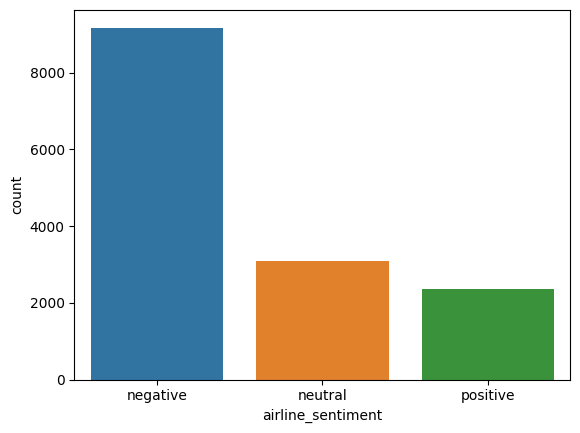

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Print the columns to see their names
print(df.columns)

# Assuming you have a column named 'airline_sentiment' based on your previous code
df['airline_sentiment'] = df['airline_sentiment'].astype('category')

# Now, you can use sns.countplot
sns.countplot(data=df, x='airline_sentiment')

plt.show()


In [5]:
import re

# Assuming you are working with the 'text' column
df.loc[:, 'text'] = df['text'].apply(lambda x: x.lower())  # Convert to lowercase
df.loc[:, 'text'] = df['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))  # Keep numbers and strings only


In [6]:
df.head(5)

,text,airline_sentiment
0,what dhepburn said,neutral
1,plus youve added commercials to the experienc...,positive
2,i didnt today must mean i need to take anothe...,neutral
3,its really aggressive to blast obnoxious ente...,negative
4,and its a really big bad thing about it,negative


In [7]:
df = df.drop(df[df.airline_sentiment == "negative"].iloc[:5000].index)

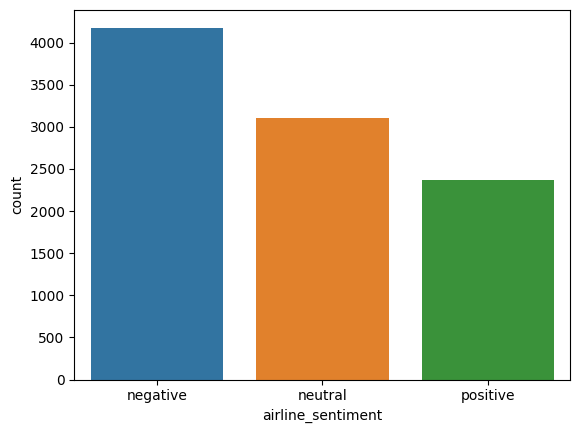

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='airline_sentiment')

plt.show()


In [9]:
max_fatures = 4000
tokenizer = Tokenizer(num_words = max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)
Y = df['airline_sentiment']
L = Y.values
X
L

['neutral', 'positive', 'neutral', 'positive', 'neutral', ..., 'positive', 'negative', 'neutral', 'negative', 'neutral']
Length: 9640
Categories (3, object): ['negative', 'neutral', 'positive']

In [10]:
k = []
for i in range(len(L)):
    if L[i] == "negative":
        k.append(0)
    elif L[i] == "positive":
        k.append(1)
    else:
        # Handle other cases or skip them based on your requirement
        pass


# **Train Test Split**

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X is a NumPy array or list of features and k is a list of labels
X = np.array(X)  # Convert X to a NumPy array if it's not already
k = np.array(k)  # Convert k to a NumPy array if it's not already

# Check if the lengths are consistent
if len(X) != len(k):
    print("Length of X:", len(X))
    print("Length of k:", len(k))
    # You might want to print the lengths to understand the inconsistency

    # Handle the inconsistency based on your data
    # For example, you could truncate or pad one of the arrays to make them consistent

    # Example of truncating the longer array
    min_length = min(len(X), len(k))
    X = X[:min_length]
    k = k[:min_length]

# Now you can proceed with train-test split
X_train, X_test, k_train, k_test = train_test_split(X, k, 
                                                    test_size=0.3, 
                                                    shuffle=True,
                                                    stratify=k,  # Ensure stratification based on labels
                                                    random_state=1)


Length of X: 9640
Length of k: 6541


# Defining the Model

In [12]:
embed_dim = 128
lstm_out = 196
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(max_fatures, 128, input_length=X_train.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.5))
model.add(tf.keras.layers.LSTM(196, dropout = 0.3, recurrent_dropout = 0.3 ))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(2, activation = tf.nn.softmax))

In [13]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Training the Model

In [14]:
import numpy as np

X_train = np.array(X_train)
Y_train = np.array(k_train)

In [15]:
import numpy as np

# Assuming X_test and Y_test are lists
X_test = np.array(X_test)
Y_test = np.array(k_test)

score = model.evaluate(X_test, k_test, verbose=False)
print("loss =", score[1]*100)
print("accuracy =", score[0]*100)


loss = 54.86500263214111
accuracy = 69.26801800727844


# **Plottiing the confusion matrix**

62/62 [==============================] - 1s 15ms/step


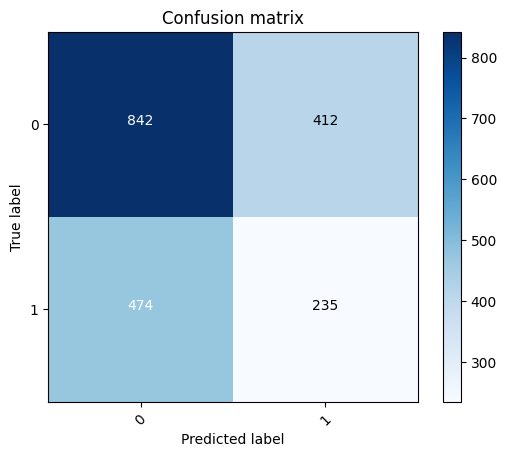

In [23]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
y_pred = model.predict(X_test) 
y_pred_classes = np.argmax(y_pred,axis = 1) 
confusion_mtx = confusion_matrix(Y_test, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))

# Model Test

In [16]:
sample = ['Meetings: Air crew is so bad.']
sample = tokenizer.texts_to_sequences(sample)
sample = pad_sequences(sample, maxlen=31, dtype='int32', value=0)
print(sample)
sentiment = model.predict(sample,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0 2285  232  172
    11   40  220]]
1/1 - 0s - 330ms/epoch - 330ms/step
negative
